In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
%matplotlib inline

In [2]:
midterm = pd.read_csv('midterm.csv')
kaggle = pd.read_csv('twitter_human_bots_dataset.csv', index_col=0)

In [3]:
midterm.head(2)

,probe_timestamp,user_id,screen_name,name,description,user_created_at,url,lang,protected,verified,...,profile_use_background_image,default_profile,followers_count,friends_count,listed_count,favourites_count,statuses_count,tid,tweet_ids,account_type
0,Tue Nov 06 20:35:08 2018,4107317134,danitheduck21,Dani🏳️‍🌈,Dani 💜 She/Her 💜 Randomness all over. Expect l...,2015-11-03 21:16:13,NaN,en,0.0,False,...,False,False,481,870,26,6542,67025,1059907055421509632,4107317134,human
1,Tue Nov 06 17:57:51 2018,4858296837,ncaraballoPR,Natalie Caraballo,"Things I don’t get tired of: Politics, Amy Win...",2016-01-28 20:03:51,NaN,en,0.0,False,...,False,False,202,712,5,1515,158,1059867472810180609,4858296837,human


In [4]:
kaggle.head(2)

,created_at,default_profile,default_profile_image,description,favourites_count,followers_count,friends_count,geo_enabled,id,lang,location,profile_background_image_url,profile_image_url,screen_name,statuses_count,verified,average_tweets_per_day,account_age_days,account_type
0,15/10/2016 21:32,False,False,"Blame @xaiax, Inspired by @MakingInvisible, us...",4,1589,4,False,7.874060e+17,en,unknown,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/7874121826...,best_in_dumbest,11041,False,7.870,1403,bot
1,09/11/2016 5:01,False,False,Photographing the American West since 1980. I ...,536,860,880,False,7.962160e+17,en,Estados Unidos,http://abs.twimg.com/images/themes/theme1/bg.png,http://pbs.twimg.com/profile_images/8023296328...,CJRubinPhoto,252,False,0.183,1379,human


In [5]:
midterm['probe_timestamp'] = pd.to_datetime(midterm['probe_timestamp'])
midterm['user_created_at'] = pd.to_datetime(midterm['user_created_at'])
kaggle['created_at'] = pd.to_datetime(kaggle['created_at'])

In [6]:
midterm['account_age_days'] = (midterm['probe_timestamp'] - midterm['user_created_at']).dt.days

In [7]:
# drop unrelated columns
midterm.drop(columns=['probe_timestamp', 'name', 'url', 'protected', 'listed_count', 'tid', 'tweet_ids'], inplace=True)

In [8]:
# drop columns not used in building the model
midterm.drop(columns=['user_id', 'screen_name', 'lang'], inplace=True)
kaggle.drop(columns=['default_profile_image', 'id', 'lang', 'location', 'profile_image_url', 'screen_name'], inplace=True)

In [9]:
kaggle.drop('average_tweets_per_day', axis=1, inplace=True)

In [10]:
# rename columns for both datasets so they have matching columns
midterm.rename(columns={'user_created_at': 'created_at', 'profile_use_background_image': 'profile_background_image_url'}, inplace=True)

In [11]:
# Refactor profile_background_image_url before .concat to prevent problems I haven't seen yet
kaggle["profile_background_image_url"] = kaggle["profile_background_image_url"].notnull().astype("int")
midterm['profile_background_image_url'].replace([True, False], [1, 0], inplace=True)

**Join the two tables together!!!**

In [12]:
df = pd.concat([kaggle, midterm])

In [13]:
df['created_at_day'] = df.created_at.dt.day
df['created_at_month'] = df.created_at.dt.month
df['created_at_year'] = df.created_at.dt.year

In [14]:
# drop created_at column
df.drop('created_at', axis=1, inplace=True)

**Make columns Machine Learning ready**

In [15]:
df['default_profile'].replace([True, False], [1, 0], inplace=True)
df["description"] = df["description"].notnull().astype("int")
df['geo_enabled'].replace([True, False], [1, 0], inplace=True)
df['verified'].replace([True, False], [1, 0], inplace=True)

In [16]:
df['account_type'].replace(['human', 'bot'], [1, 0], inplace=True)

Cant forget to drop duplicates.

In [17]:
df = df.drop_duplicates()

## Machine Learning

In [18]:
from sklearn.model_selection import train_test_split # splitting the data
from sklearn.preprocessing import StandardScaler # normalizing the data
from sklearn.preprocessing import MinMaxScaler # normalizing the data
from sklearn.model_selection import KFold # use for cross validation
from sklearn.model_selection import GridSearchCV # tuning model parameters
from sklearn.neighbors import KNeighborsClassifier # KNN
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.tree import DecisionTreeClassifier # Decision trees
from sklearn.naive_bayes import GaussianNB # Naive Bayes
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # Accuracy metrics

In [19]:
df.sample(5)

,default_profile,description,favourites_count,followers_count,friends_count,geo_enabled,profile_background_image_url,statuses_count,verified,account_age_days,account_type,created_at_day,created_at_month,created_at_year
19831,1,1,286,23,14,0,1,357,0,2,0,13,10,2018
23282,0,1,133,822,46,0,1,4286,0,1995,1,3,3,2015
45929,1,1,11,3,67,0,1,19,0,0,0,15,11,2018
46400,1,1,0,0,16,0,1,1,0,0,0,18,11,2018
28094,0,1,360,36,109,1,1,263,0,4162,1,28,3,2009


In [20]:
X = df.drop('account_type', axis=1)
y = df['account_type']

In [21]:
# split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
sc = MinMaxScaler()
col_to_scale = ['followers_count', 'friends_count', 'favourites_count', 'statuses_count', 'account_age_days',
                'created_at_day', 'created_at_month', 'created_at_year']
X_train[col_to_scale] = sc.fit_transform(X_train[col_to_scale])
X_test[col_to_scale] = sc.transform(X_test[col_to_scale])

<ipython-input-22-8806f3e2a1e2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col_to_scale] = sc.fit_transform(X_train[col_to_scale])
C:\Users\ugonn\anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
<ipython-input-22-8806f3e2a1e2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

## K Nearest Neighbors

In [23]:
# create the model
knn = KNeighborsClassifier(n_neighbors=5)

# fit the model
knn.fit(X_train, y_train)

# predict using unseen data
y_pred = knn.predict(X_test)

clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
print("Test Result:\n================================================")        
print(f"Accuracy Score: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{clf_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}\n")

# compare and calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"KNN's accuracy is {accuracy}")

Test Result:
Accuracy Score: 86.26%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy     macro avg  weighted avg
precision     0.885280     0.833608  0.862625      0.859444      0.863066
recall        0.872037     0.850145  0.862625      0.861091      0.862625
f1-score      0.878609     0.841795  0.862625      0.860202      0.862782
support    8690.000000  6553.000000  0.862625  15243.000000  15243.000000
_______________________________________________
Confusion Matrix: 
 [[7578 1112]
 [ 982 5571]]

KNN's accuracy is 0.8626254674276718


**Explaining Confusion Matrix**
* 0,0 - True Negative
* 0,1 - False Positive
* 1,0 - False Negative
* 1,1 - True Positive

## Random Forest

In [24]:
# create the model
rf = RandomForestClassifier()

# fit the model
rf.fit(X_train, y_train)

# predict using unseen data
y_pred = rf.predict(X_test)

clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
print("Test Result:\n================================================")        
print(f"Accuracy Score: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{clf_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}\n")

# compare and calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Random Forest's accuracy is {accuracy}")

Test Result:
Accuracy Score: 93.21%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy     macro avg  weighted avg
precision     0.963322     0.895159    0.9321      0.929240      0.934018
recall        0.915765     0.953762    0.9321      0.934763      0.932100
f1-score      0.938942     0.923532    0.9321      0.931237      0.932317
support    8690.000000  6553.000000    0.9321  15243.000000  15243.000000
_______________________________________________
Confusion Matrix: 
 [[7958  732]
 [ 303 6250]]

Random Forest's accuracy is 0.9320999803188349


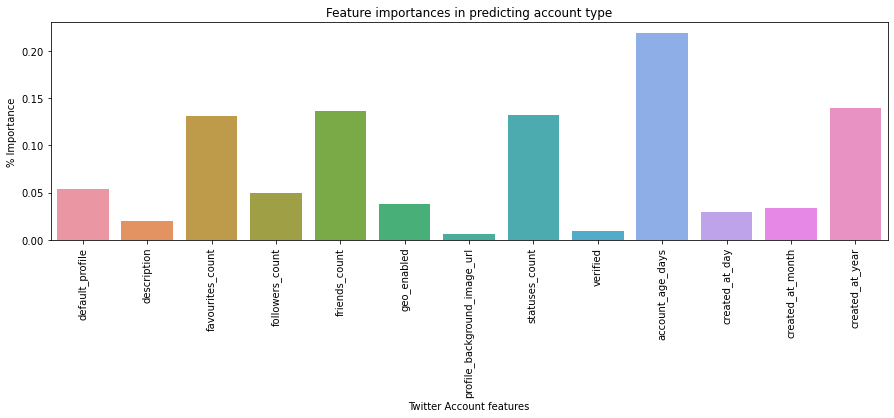

In [25]:
# plot feature importances using random forest method
figure(figsize=(15, 4))

# Plot the result.
sns.barplot(x=X.columns, y=rf.feature_importances_, ci=None);

# labels and title
plt.xticks(rotation=90);
plt.title('Feature importances in predicting account type');
plt.ylabel('% Importance');
plt.xlabel('Twitter Account features');

## Decision Trees

In [26]:
# create the model
dt = DecisionTreeClassifier()

# fit the model
dt.fit(X_train, y_train)

# predict using unseen data
y_pred = dt.predict(X_test)

clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
print("Test Result:\n================================================")        
print(f"Accuracy Score: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{clf_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}\n")

# compare and calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Decision Tree's accuracy is {accuracy}")

Test Result:
Accuracy Score: 90.08%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy     macro avg  weighted avg
precision     0.912339     0.885456  0.900807      0.898898      0.900782
recall        0.913809     0.883565  0.900807      0.898687      0.900807
f1-score      0.913073     0.884510  0.900807      0.898792      0.900794
support    8690.000000  6553.000000  0.900807  15243.000000  15243.000000
_______________________________________________
Confusion Matrix: 
 [[7941  749]
 [ 763 5790]]

Decision Tree's accuracy is 0.9008069277701239


## Naive Bayes

In [27]:
# create the model
gnb = GaussianNB()

# fit the model
gnb.fit(X_train, y_train)

# predict using unseen data
y_pred = gnb.predict(X_test)

clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
print("Test Result:\n================================================")        
print(f"Accuracy Score: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{clf_report}")
print("_______________________________________________")
print(f"Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}\n")

# compare and calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Naive Bayes' accuracy is {accuracy}")
print(f"Number of correctly labeled points out of a total {X_test.shape[0]} points : {(y_test == y_pred).sum()}")

Test Result:
Accuracy Score: 84.33%
_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy     macro avg  weighted avg
precision     0.835498     0.855922  0.843338      0.845710      0.844279
recall        0.902992     0.764230  0.843338      0.833611      0.843338
f1-score      0.867935     0.807481  0.843338      0.837708      0.841946
support    8690.000000  6553.000000  0.843338  15243.000000  15243.000000
_______________________________________________
Confusion Matrix: 
 [[7847  843]
 [1545 5008]]

Naive Bayes' accuracy is 0.8433379256051958
Number of correctly labeled points out of a total 15243 points : 12855


# Test with another dataset to confirm accuracy [Celebrity]

In [28]:
celebrity = pd.read_csv('celebrity.csv')

In [29]:
celebrity['created_at'] = pd.to_datetime(celebrity['created_at'])

In [30]:
celebrity.created_at.min(), celebrity.created_at.max()

(Timestamp('2006-10-24 03:32:27+0000', tz='UTC'),
 Timestamp('2017-10-29 13:31:55+0000', tz='UTC'))

In [31]:
celebrity['probe_timestamp'] = '2019-10-27'

In [32]:
celebrity['probe_timestamp'] = pd.to_datetime(celebrity['probe_timestamp'])

In [33]:
celebrity['created_at'] = celebrity['created_at'].dt.date

In [34]:
celebrity['created_at'] = pd.to_datetime(celebrity['created_at'])

In [35]:
celebrity['account_age_days'] = (celebrity['probe_timestamp'] - celebrity['created_at']).dt.days

In [36]:
# drop columns not used in building the model
celebrity.drop(columns=['default_profile_image', 'id', 'lang', 'location', 'profile_image_url',
                        'screen_name', 'probe_timestamp', 'tweet_ids'], inplace=True)

In [37]:
# Refactor profile_background_image_url
celebrity["profile_background_image_url"] = celebrity["profile_background_image_url"].notnull().astype("int")

In [38]:
celebrity['created_at_day'] = celebrity.created_at.dt.day
celebrity['created_at_month'] = celebrity.created_at.dt.month
celebrity['created_at_year'] = celebrity.created_at.dt.year

In [39]:
# drop created_at column
celebrity.drop('created_at', axis=1, inplace=True)

**Make columns Machine Learning ready**

In [40]:
celebrity['default_profile'].replace([True, False], [1, 0], inplace=True)
celebrity["description"] = celebrity["description"].notnull().astype("int")
celebrity['geo_enabled'].replace([True, False], [1, 0], inplace=True)
celebrity['verified'].replace([True, False], [1, 0], inplace=True)

In [41]:
celebrity['account_type'].replace(['human', 'bot'], [1, 0], inplace=True)

In [42]:
celebrity.head()

,default_profile,description,favourites_count,followers_count,friends_count,geo_enabled,profile_background_image_url,statuses_count,verified,account_type,account_age_days,created_at_day,created_at_month,created_at_year
0,0,1,13561,651238,665,0,1,39411,1,1,4100,5,8,2008
1,0,1,11365,265102,943,0,1,41187,1,1,3785,16,6,2009
2,1,1,76,2724932,14,0,1,310,1,1,2089,6,2,2014
3,0,1,111,727503,293,1,1,16689,1,1,3845,17,4,2009
4,0,1,6215,1845847,686,1,1,4977,1,1,3758,13,7,2009


## Machine Learning

In [43]:
X_celebrity = celebrity.drop('account_type', axis=1)
y_celebrity = celebrity['account_type']

In [44]:
col_to_scale = ['followers_count', 'friends_count', 'favourites_count', 'statuses_count', 'account_age_days',
                'created_at_day', 'created_at_month', 'created_at_year']
X_celebrity[col_to_scale] = sc.transform(X_celebrity[col_to_scale])

## KNN

In [45]:
# predict using unseen data
y_pred = knn.predict(X_celebrity)

# compare and calculate accuracy
accuracy = accuracy_score(y_celebrity, y_pred)

print(f"KNN's accuracy is {accuracy}")

KNN's accuracy is 0.9560662385941197


## Random Forest

In [46]:
# predict using unseen data
y_pred = rf.predict(X_celebrity)

# compare and calculate accuracy
accuracy = accuracy_score(y_celebrity, y_pred)

print(f"Random Forest's accuracy is {accuracy}")

Random Forest's accuracy is 0.9954376478540047


## Decision Trees

In [47]:
# predict using unseen data
y_pred = dt.predict(X_celebrity)

# compare and calculate accuracy
accuracy = accuracy_score(y_celebrity, y_pred)

print(f"Decision Tree's accuracy is {accuracy}")

Decision Tree's accuracy is 0.9560662385941197


# Test with another dataset to confirm accuracy [Pronbots]

In [48]:
pronbots = pd.read_csv('pronbots.csv')

In [49]:
pronbots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17882 entries, 0 to 17881
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   created_at                    17882 non-null  object
 1   default_profile               17882 non-null  bool  
 2   default_profile_image         17882 non-null  bool  
 3   description                   17807 non-null  object
 4   favourites_count              17882 non-null  int64 
 5   followers_count               17882 non-null  int64 
 6   friends_count                 17882 non-null  int64 
 7   geo_enabled                   17882 non-null  bool  
 8   id                            17882 non-null  int64 
 9   lang                          17882 non-null  object
 10  location                      3032 non-null   object
 11  profile_background_image_url  16337 non-null  object
 12  profile_image_url             17880 non-null  object
 13  screen_name     

In [50]:
pronbots['created_at'] = pd.to_datetime(pronbots['created_at'])

In [51]:
pronbots.created_at.min(), pronbots.created_at.max()

(Timestamp('2007-06-20 05:10:39+0000', tz='UTC'),
 Timestamp('2018-03-07 19:09:23+0000', tz='UTC'))

In [52]:
pronbots['probe_timestamp'] = '2019-05-13'

In [53]:
pronbots['probe_timestamp'] = pd.to_datetime(pronbots['probe_timestamp'])

In [54]:
pronbots['created_at'] = pronbots['created_at'].dt.date

In [55]:
pronbots['created_at'] = pd.to_datetime(pronbots['created_at'])

In [56]:
pronbots['account_age_days'] = (pronbots['probe_timestamp'] - pronbots['created_at']).dt.days

In [57]:
# drop columns not used in building the model
pronbots.drop(columns=['default_profile_image', 'id', 'lang', 'location', 'profile_image_url',
                        'screen_name', 'probe_timestamp', 'tweet_ids'], inplace=True)

In [58]:
# Refactor profile_background_image_url
pronbots["profile_background_image_url"] = pronbots["profile_background_image_url"].notnull().astype("int")

In [59]:
pronbots['created_at_day'] = pronbots.created_at.dt.day
pronbots['created_at_month'] = pronbots.created_at.dt.month
pronbots['created_at_year'] = pronbots.created_at.dt.year

In [60]:
# drop created_at column
pronbots.drop('created_at', axis=1, inplace=True)

**Make columns Machine Learning ready**

In [61]:
pronbots['default_profile'].replace([True, False], [1, 0], inplace=True)
pronbots["description"] = pronbots["description"].notnull().astype("int")
pronbots['geo_enabled'].replace([True, False], [1, 0], inplace=True)
pronbots['verified'].replace([True, False], [1, 0], inplace=True)

In [62]:
pronbots['account_type'].replace(['human', 'bot'], [1, 0], inplace=True)

In [63]:
pronbots.head()

,default_profile,description,favourites_count,followers_count,friends_count,geo_enabled,profile_background_image_url,statuses_count,verified,account_type,account_age_days,created_at_day,created_at_month,created_at_year
0,0,1,515,42,240,0,1,101,0,0,3483,29,10,2009
1,1,1,187,16,0,0,1,38,0,0,3394,26,1,2010
2,1,1,178,7,0,0,1,32,0,0,2020,31,10,2013
3,1,1,838,99,500,0,1,145,0,0,3147,30,9,2010
4,1,1,628,59,419,0,1,39,0,0,2400,16,10,2012


## Machine Learning

In [64]:
X_pronbots = pronbots.drop('account_type', axis=1)
y_pronbots = pronbots['account_type']

In [65]:
col_to_scale = ['followers_count', 'friends_count', 'favourites_count', 'statuses_count', 'account_age_days',
                'created_at_day', 'created_at_month', 'created_at_year']
X_pronbots[col_to_scale] = sc.transform(X_pronbots[col_to_scale])

## KNN

In [66]:
# predict using unseen data
y_pred = knn.predict(X_pronbots)

# compare and calculate accuracy
accuracy = accuracy_score(y_pronbots, y_pred)

print(f"KNN's accuracy is {accuracy}")

KNN's accuracy is 0.4513477239682362


## Random Forest

In [67]:
# predict using unseen data
y_pred = rf.predict(X_pronbots)

# compare and calculate accuracy
accuracy = accuracy_score(y_pronbots, y_pred)

print(f"Random Forest's accuracy is {accuracy}")

Random Forest's accuracy is 0.8801028967676994


## Decision Trees

In [68]:
# predict using unseen data
y_pred = dt.predict(X_pronbots)

# compare and calculate accuracy
accuracy = accuracy_score(y_pronbots, y_pred)

print(f"Decision Tree's accuracy is {accuracy}")

Decision Tree's accuracy is 0.8701487529359132


# Test with another dataset to confirm accuracy [Cresci]

In [71]:
cresci = pd.read_csv('cresci.csv')

In [72]:
cresci.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13276 entries, 0 to 13275
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   created_at                    13276 non-null  object
 1   default_profile               13276 non-null  bool  
 2   default_profile_image         13276 non-null  bool  
 3   description                   8636 non-null   object
 4   favourites_count              13276 non-null  int64 
 5   followers_count               13276 non-null  int64 
 6   friends_count                 13276 non-null  int64 
 7   geo_enabled                   13276 non-null  bool  
 8   id                            13276 non-null  int64 
 9   lang                          13276 non-null  object
 10  location                      7258 non-null   object
 11  profile_background_image_url  10746 non-null  object
 12  profile_image_url             13276 non-null  object
 13  screen_name     

In [73]:
cresci['created_at'] = pd.to_datetime(cresci['created_at'])

In [74]:
cresci.created_at.min(), cresci.created_at.max()

(Timestamp('2006-07-05 19:52:46+0000', tz='UTC'),
 Timestamp('2017-09-04 09:12:41+0000', tz='UTC'))

In [75]:
cresci['probe_timestamp'] = '2018-09-04'

In [76]:
cresci['probe_timestamp'] = pd.to_datetime(cresci['probe_timestamp'])

In [77]:
cresci['created_at'] = cresci['created_at'].dt.date

In [78]:
cresci['created_at'] = pd.to_datetime(cresci['created_at'])

In [79]:
cresci['account_age_days'] = (cresci['probe_timestamp'] - cresci['created_at']).dt.days

In [80]:
# drop columns not used in building the model
cresci.drop(columns=['default_profile_image', 'id', 'lang', 'location', 'profile_image_url',
                        'screen_name', 'probe_timestamp', 'tweet_ids'], inplace=True)

In [81]:
# Refactor profile_background_image_url
cresci["profile_background_image_url"] = cresci["profile_background_image_url"].notnull().astype("int")

In [82]:
cresci['created_at_day'] = cresci.created_at.dt.day
cresci['created_at_month'] = cresci.created_at.dt.month
cresci['created_at_year'] = cresci.created_at.dt.year

In [83]:
# drop created_at column
cresci.drop('created_at', axis=1, inplace=True)

**Make columns Machine Learning ready**

In [84]:
cresci['default_profile'].replace([True, False], [1, 0], inplace=True)
cresci["description"] = cresci["description"].notnull().astype("int")
cresci['geo_enabled'].replace([True, False], [1, 0], inplace=True)
cresci['verified'].replace([True, False], [1, 0], inplace=True)

In [85]:
cresci['account_type'].replace(['human', 'bot'], [1, 0], inplace=True)

In [86]:
cresci.head()

,default_profile,description,favourites_count,followers_count,friends_count,geo_enabled,profile_background_image_url,statuses_count,verified,account_type,account_age_days,created_at_day,created_at_month,created_at_year
0,1,1,2148,6,12,0,1,2962,0,0,2722,23,3,2011
1,1,1,16843,1716,2466,0,1,7993,0,1,1822,8,9,2013
2,0,1,9880,2010,684,1,1,64568,0,1,1911,11,6,2013
3,0,0,2419,220,0,1,1,3919,0,0,2258,29,6,2012
4,1,1,31688,404,313,1,0,24867,0,1,919,28,2,2016


## Machine Learning

In [87]:
X_cresci = cresci.drop('account_type', axis=1)
y_cresci = cresci['account_type']

In [88]:
col_to_scale = ['followers_count', 'friends_count', 'favourites_count', 'statuses_count', 'account_age_days',
                'created_at_day', 'created_at_month', 'created_at_year']
X_cresci[col_to_scale] = sc.transform(X_cresci[col_to_scale])

## KNN

In [89]:
# predict using unseen data
y_pred = knn.predict(X_cresci)

# compare and calculate accuracy
accuracy = accuracy_score(y_cresci, y_pred)

print(f"KNN's accuracy is {accuracy}")

KNN's accuracy is 0.5753992166315155


## Random Forest

In [90]:
# predict using unseen data
y_pred = rf.predict(X_cresci)

# compare and calculate accuracy
accuracy = accuracy_score(y_cresci, y_pred)

print(f"Random Forest's accuracy is {accuracy}")

Random Forest's accuracy is 0.808677312443507


## Decision Trees

In [91]:
# predict using unseen data
y_pred = dt.predict(X_cresci)

# compare and calculate accuracy
accuracy = accuracy_score(y_cresci, y_pred)

print(f"Decision Tree's accuracy is {accuracy}")

Decision Tree's accuracy is 0.6984784573666767
